In [11]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score
import time
import torchvision
import torchvision.transforms as transforms
import matplotlib.cm as cm
import matplotlib as mpl
import copy
from sklearn.utils.class_weight import compute_class_weight
import statsmodels.formula.api as sm

import sys 
sys.path.append('../src/')
from DVGS import DVGS
from utils import get_corruption_scores
from NN import NN
from utils import load_data 
import similarities

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
x_train, y_train, x_valid, y_valid, x_test, y_test, exog_noise, endog_noise, kwargs = load_data(dataset     = 'adult', 
                                                                                                    train_num   = 1000, 
                                                                                                    valid_num   = 400, 
                                                                                                    exog_noise  = 0., 
                                                                                                    endog_noise = 0.2, 
                                                                                                    save_dir    = f'../temp-data/', 
                                                                                                    clean_up    = True,
                                                                                                    transforms  = None)

In [3]:
noise_idx = endog_noise.nonzero()[0]

In [4]:
classes = list(np.sort(np.unique(y_train.detach().numpy())).astype(int))

In [8]:
balance_class_weights_options   = [True, False]
dropout_options                 = [0., 0.25, 0.5, 0.75]
batch_size_options              = [100,200,400]
similarity_options              = [similarities.C_dist(), similarities.cosine_similarity(), similarities.dot_product(), similarities.scalar_projection()]
lr_options                      = [1e-2,1e-3,1e-4]
norm_options                    = [True, False]
num_layer_options               = [1,2]
act_options                     = [torch.nn.Mish, torch.nn.ReLU]
num_repl                        = 2

In [9]:
def run(bal_class_weight, dropout, batch_size, similarity, lr, norm, num_layer, act): 
    
    model = NN(in_channels      = 108, 
            out_channels     = 2, 
            num_layers       = num_layer, 
            hidden_channels  = 100, 
            norm             = norm, 
            dropout          = dropout, 
            bias             = True, 
            act              = act, 
            out_fn           = None)

    dvgs = DVGS(x_source         = x_train,
                y_source         = y_train, 
                x_target         = x_valid,  
                y_target         = y_valid, 
                model            = copy.deepcopy(model))

    if bal_class_weight: 
        class_weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=classes, y=y_valid.detach().numpy().ravel()), dtype=torch.float).to('cuda')
    else: 
        class_weights = None # torch.tensor([0.5, 1.]).to('cuda')

    CEL = torch.nn.CrossEntropyLoss(weight=class_weights) 

    tic = time.time() 
    run_id = dvgs.run(target_crit               = lambda x,y: CEL(x,y.squeeze(1)), 
                    source_crit               = lambda x,y: torch.nn.functional.cross_entropy(x, y.squeeze(1)),
                    num_restarts              = 1,
                    save_dir                  = '../results/',
                    similarity                = similarity,
                    optim                     = torch.optim.Adam, 
                    lr                        = lr,
                    num_epochs                = 100, 
                    compute_every             = 1, 
                    source_batch_size         = 500, 
                    target_batch_size         = batch_size,
                    grad_params               = None, 
                    verbose                   = False, 
                    use_cuda                  = True)

    vals_dvgs = dvgs.agg(f'../results/{run_id}/')
    dvgs.clean(f'../results/{run_id}/')

    auroc = roc_auc_score(endog_noise, -vals_dvgs)

    print(f'{(bal_class_weight, dropout, batch_size, similarity, lr, norm, num_layer, act)} || auroc: {auroc:.3f} || time elapsed: {(time.time() - tic)/60:.2f} min')

    return auroc

In [10]:
res = {'balance_class_weights':[],
       'dropout':[],
       'batch_size':[],
       'similarity':[],
       'lr':[],
       'norm':[],
       'num_layer':[],
       'act':[],
       'auroc':[]}


for bal_class_weight in balance_class_weights_options: 
    for dropout in dropout_options: 
        for batch_size in batch_size_options: 
            for similarity in similarity_options: 
                for lr in lr_options: 
                    for norm in norm_options: 
                        for num_layer in num_layer_options: 
                            for act in act_options:  

                                res['balance_class_weights'].append(bal_class_weight)
                                res['dropout'].append(dropout)
                                res['batch_size'].append(batch_size)
                                res['similarity'].append(similarity)
                                res['lr'].append(lr)
                                res['norm'].append(norm)
                                res['num_layer'].append(num_layer)
                                res['act'].append(act)
                                res['auroc'].append(run(bal_class_weight, dropout, batch_size, similarity, lr, norm, num_layer, act))
                                
res = pd.DataFrame(res)


(True, 0.0, 100, <function C_dist.<locals>.<lambda> at 0x7f6c46542550>, 0.01, True, 1, <class 'torch.nn.modules.activation.Mish'>) || auroc: 0.824 || time elapsed: 0.08 min
(True, 0.0, 100, <function C_dist.<locals>.<lambda> at 0x7f6c46542550>, 0.01, True, 1, <class 'torch.nn.modules.activation.ReLU'>) || auroc: 0.800 || time elapsed: 0.07 min
(True, 0.0, 100, <function C_dist.<locals>.<lambda> at 0x7f6c46542550>, 0.01, True, 2, <class 'torch.nn.modules.activation.Mish'>) || auroc: 0.775 || time elapsed: 0.11 min
(True, 0.0, 100, <function C_dist.<locals>.<lambda> at 0x7f6c46542550>, 0.01, True, 2, <class 'torch.nn.modules.activation.ReLU'>) || auroc: 0.778 || time elapsed: 0.10 min
(True, 0.0, 100, <function C_dist.<locals>.<lambda> at 0x7f6c46542550>, 0.01, False, 1, <class 'torch.nn.modules.activation.Mish'>) || auroc: 0.876 || time elapsed: 0.07 min
(True, 0.0, 100, <function C_dist.<locals>.<lambda> at 0x7f6c46542550>, 0.01, False, 1, <class 'torch.nn.modules.activation.ReLU'>) ||

In [12]:
res.head()

,balance_class_weights,dropout,batch_size,similarity,lr,norm,num_layer,act,auroc
0,True,0.0,100,<function C_dist.<locals>.<lambda> at 0x7f6c46...,0.01,True,1,<class 'torch.nn.modules.activation.Mish'>,0.823856
1,True,0.0,100,<function C_dist.<locals>.<lambda> at 0x7f6c46...,0.01,True,1,<class 'torch.nn.modules.activation.ReLU'>,0.799625
2,True,0.0,100,<function C_dist.<locals>.<lambda> at 0x7f6c46...,0.01,True,2,<class 'torch.nn.modules.activation.Mish'>,0.774806
3,True,0.0,100,<function C_dist.<locals>.<lambda> at 0x7f6c46...,0.01,True,2,<class 'torch.nn.modules.activation.ReLU'>,0.778169
4,True,0.0,100,<function C_dist.<locals>.<lambda> at 0x7f6c46...,0.01,False,1,<class 'torch.nn.modules.activation.Mish'>,0.875587


In [16]:
res.sort_values('auroc').tail(10)

,balance_class_weights,dropout,batch_size,similarity,lr,norm,num_layer,act,auroc
1959,False,0.50,400,CosineSimilarity(),0.001,False,2,<class 'torch.nn.modules.activation.ReLU'>,0.906112
1260,False,0.00,200,<function C_dist.<locals>.<lambda> at 0x7f6c46...,0.001,False,1,<class 'torch.nn.modules.activation.Mish'>,0.906219
1934,False,0.50,400,<function C_dist.<locals>.<lambda> at 0x7f6c46...,0.001,False,2,<class 'torch.nn.modules.activation.Mish'>,0.906381
2124,False,0.75,200,<function C_dist.<locals>.<lambda> at 0x7f6c46...,0.001,False,1,<class 'torch.nn.modules.activation.Mish'>,0.906588
1836,False,0.50,200,<function C_dist.<locals>.<lambda> at 0x7f6c46...,0.001,False,1,<class 'torch.nn.modules.activation.Mish'>,0.906800
134,True,0.00,200,CosineSimilarity(),0.001,False,2,<class 'torch.nn.modules.activation.Mish'>,0.906931
1333,False,0.00,200,<function scalar_projection.<locals>.<lambda> ...,0.001,False,1,<class 'torch.nn.modules.activation.ReLU'>,0.907169
1671,False,0.25,400,CosineSimilarity(),0.001,False,2,<class 'torch.nn.modules.activation.ReLU'>,0.907525
1548,False,0.25,200,<function C_dist.<locals>.<lambda> at 0x7f6c46...,0.001,False,1,<class 'torch.nn.modules.activation.Mish'>,0.908050
1477,False,0.25,100,CosineSimilarity(),0.001,False,1,<class 'torch.nn.modules.activation.ReLU'>,0.908100


In [19]:
res.to_csv('../results/hyperparam_analysis_res.csv', index=False)

In [61]:
for c in list(res.columns[1:]): 
    temp = res.groupby(c)[['auroc']].mean().sort_values(by='auroc', ascending=False)
    print(c)
    print(temp)
    print()

dropout
            auroc
dropout          
0.25     0.802260
0.00     0.798281
0.50     0.790685
0.75     0.771569

batch_size
               auroc
batch_size          
200         0.792381
400         0.790541
100         0.789175

similarity
                                                       auroc
similarity                                                  
<function C_dist.<locals>.<lambda> at 0x7f6c465...  0.837023
CosineSimilarity()                                  0.832170
<function scalar_projection.<locals>.<lambda> a...  0.762140
<function dot_product.<locals>.<lambda> at 0x7f...  0.731462

lr
           auroc
lr              
0.0010  0.832690
0.0001  0.805989
0.0100  0.733417

norm
          auroc
norm           
True   0.794775
False  0.786622

num_layer
              auroc
num_layer          
1          0.802693
2          0.778705

act
                                               auroc
act                                                 
<class 'torch.nn.modules.act

ValueError: 'auroc' is both an index level and a column label, which is ambiguous.

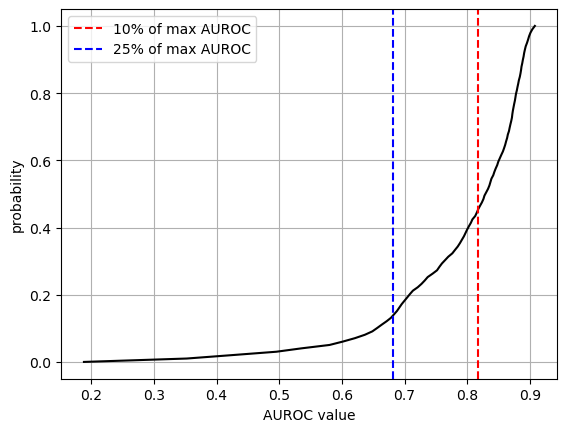

In [57]:
q = np.linspace(0,1, 100)
res2 = res.groupby(list(res.columns[:-1]))[['auroc']].mean()
cdf = [res2.auroc.quantile(qq) for qq in q]

plt.figure()
plt.plot(cdf, q, 'k-')
plt.axvline(res2.auroc.max() - (res2.auroc.max() * 0.1), c='r', label='10% of max AUROC', linestyle='--')
plt.axvline(res2.auroc.max() - (res2.auroc.max() * 0.25), c='b', label='25% of max AUROC', linestyle='--')
plt.grid(visible=True) 
plt.legend()
plt.ylabel('probability')
plt.xlabel('AUROC value')
plt.savefig('../results/hyperparam_cdf.png', dpi=300)
plt.show()

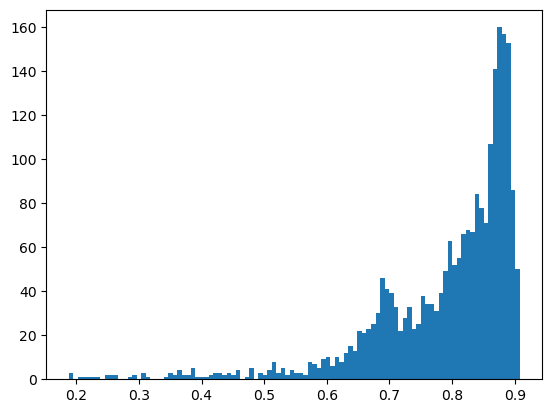

In [17]:
plt.figure()
plt.hist(res.auroc.values, bins=100)
plt.show()

In [31]:
res.similarity = [str(x) for x in res.similarity.values]
res.act = [str(x) for x in res.act.values]

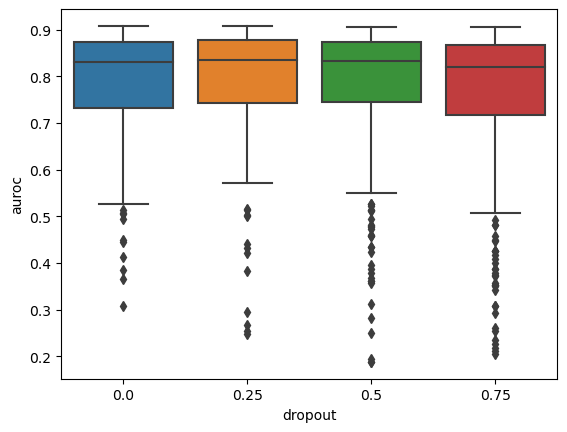

In [23]:
plt.figure()
sbn.boxplot(x='dropout', y='auroc', data=res)
plt.show()

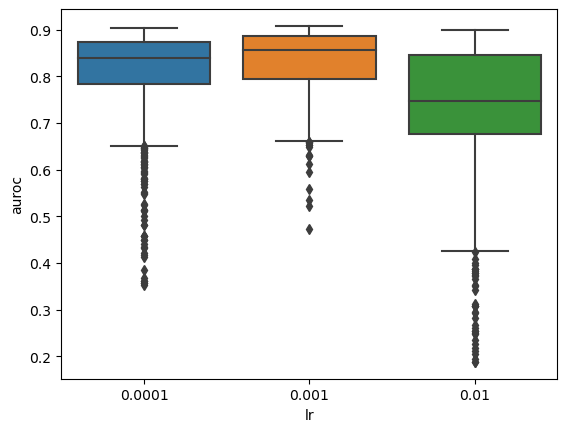

In [24]:
plt.figure()
sbn.boxplot(x='lr', y='auroc', data=res)
plt.show()

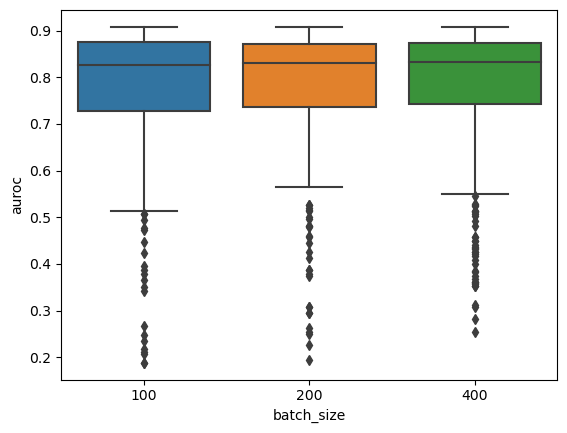

In [25]:
plt.figure()
sbn.boxplot(x='batch_size', y='auroc', data=res)
plt.show()

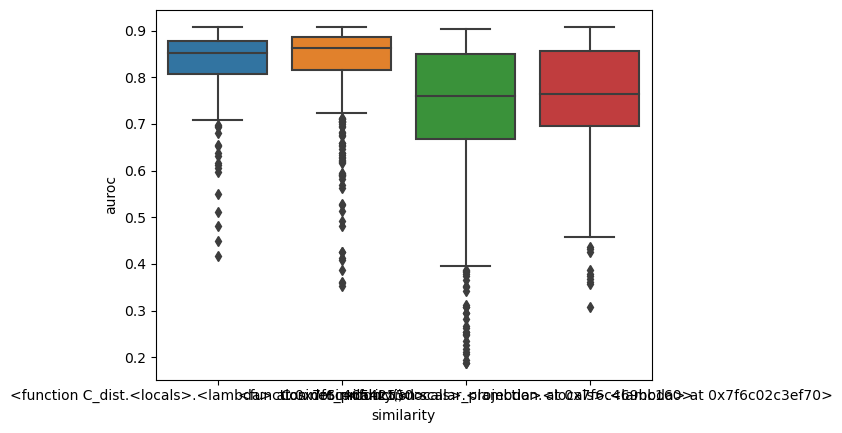

In [28]:
plt.figure()
sbn.boxplot(x='similarity', y='auroc', data=res)
plt.show()

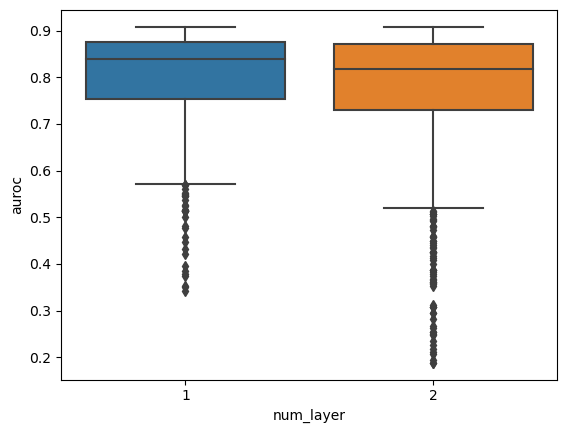

In [29]:
plt.figure()
sbn.boxplot(x='num_layer', y='auroc', data=res)
plt.show()

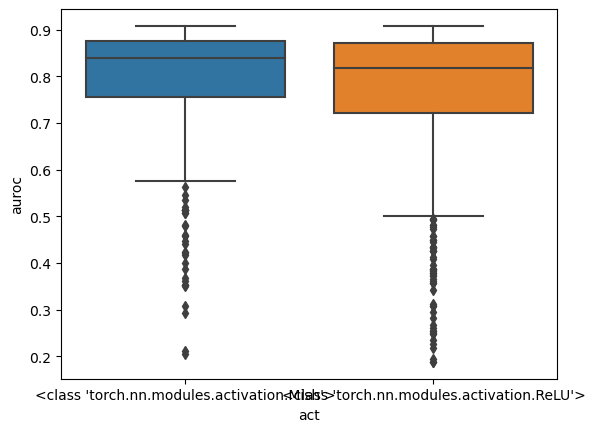

In [32]:
plt.figure()
sbn.boxplot(x='act', y='auroc', data=res)
plt.show()

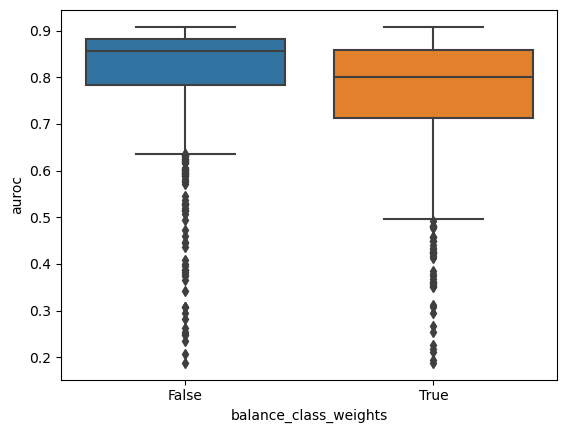

In [33]:
plt.figure()
sbn.boxplot(x='balance_class_weights', y='auroc', data=res)
plt.show()

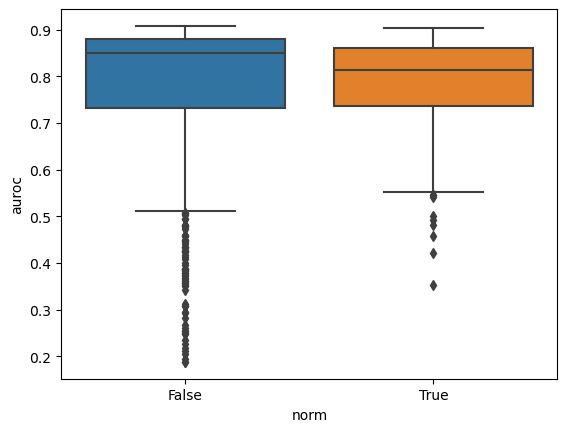

In [35]:
plt.figure()
sbn.boxplot(x='norm', y='auroc', data=res)
plt.show()

In [20]:
result = sm.ols(formula="auroc ~ balance_class_weights + dropout + batch_size + similarity + lr + norm + num_layer + act", data=res).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  auroc   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     116.0
Date:                Fri, 10 Mar 2023   Prob (F-statistic):          1.39e-195
Time:                        17:29:47   Log-Likelihood:                 2177.4
No. Observations:                2304   AIC:                            -4333.
Df Residuals:                    2293   BIC:                            -4270.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================
                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                          0.9178      0.009     99.670      0.000       0.900       0.936
balance_class_weights[T.True]                                                     -0.0417      0.004    -10.619      0.000      -0.049      -0.034
similarity[T.<function scalar_projection.<locals>.<lambda> at 0x7f6c02c3ef70>]    -0.0700      0.006    -12.607      0.000      -0.081      -0.059
similarity[T.<function C_dist.<locals>.<lambda> at 0x7f6c46542550>]                0.0049      0.006      0.874      0.382      -0.006       0.016
similarity[T.<function dot_product.<locals>.<lambda> at 0x7f6c469bc160>]          -0.1007      0.006    -18.130      0.000      -0.112      -0.090
norm[T.True]                                                                       0.0082      0.004      2.076      0.038       0.000       0.016
act[T.<class 'torch.nn.modules.activation.Mish'>]                                  0.0259      0.004      6.590      0.000       0.018       0.034
dropout                                                                           -0.0367      0.007     -5.221      0.000      -0.050      -0.023
batch_size                                                                      2.588e-06   1.57e-05      0.164      0.869   -2.83e-05    3.35e-05
lr                                                                                -8.8304      0.439    -20.098      0.000      -9.692      -7.969
num_layer                                                                         -0.0240      0.004     -6.107      0.000      -0.032      -0.016
==============================================================================
Omnibus:                      830.605   Durbin-Watson:                   1.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3357.333
Skew:                          -1.731   Prob(JB):                         0.00
Kurtosis:                       7.795   Cond. No.                     5.92e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.92e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""